
Final quantum state (states' amplitudes):
Statevector([-1.26316153e-34+0.j, -2.36158002e-17+0.j, -9.52420783e-18+0.j,
             -1.00000000e+00+0.j],
            dims=(2, 2))


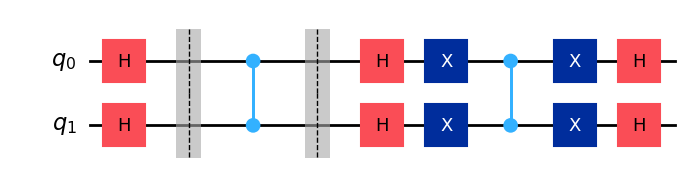

In [1]:
# Frist try: Basic Grover

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Circuit definition
grover_circuit = QuantumCircuit(2)

# Initial superposition
grover_circuit.h([0, 1])
grover_circuit.barrier()

# Oracle
grover_circuit.cz(0, 1)
grover_circuit.barrier()

# Diffuser
grover_circuit.h([0, 1])
grover_circuit.x([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.x([0, 1])
grover_circuit.h([0, 1])

# Measurement
final_state = Statevector.from_instruction(grover_circuit)

# Results
print("\nFinal quantum state (states' amplitudes):")
print(final_state)
grover_circuit.draw(output="mpl")


Final quantum state (states' amplitudes):
Statevector([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
            dims=(2, 2))


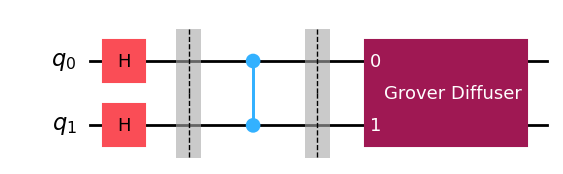

In [2]:
# Second try: Generalized difusser

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def grover_diffuser(n_qubits: int) -> QuantumCircuit:
    """
    Creates the Grover diffuser circuit for n_qubits.
    """
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    if n_qubits == 2:
        qc.cz(0, 1)
    else:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    qc.name = "Grover Diffuser"
    return qc

# Fixed number of qubits and marked state
n = 2  # number of qubits

# Define the Grover circuit
grover_circuit = QuantumCircuit(n)

# Initial superposition
grover_circuit.h(range(n))
grover_circuit.barrier()

# Oracle for state |11⟩
grover_circuit.cz(0, 1)
grover_circuit.barrier()

# Grover diffuser
grover_circuit.append(grover_diffuser(n), range(n))

# Get final state
final_state = Statevector.from_instruction(grover_circuit)

# Print amplitudes
print("\nFinal quantum state (states' amplitudes):")
print(final_state)

# Draw circuit
grover_circuit.draw("mpl")



Final quantum state (states' amplitudes):
Statevector([-0.1767767 +0.j, -0.1767767 +0.j, -0.1767767 +0.j,
             -0.1767767 +0.j, -0.1767767 +0.j, -0.88388348+0.j,
             -0.1767767 +0.j, -0.1767767 +0.j],
            dims=(2, 2, 2))


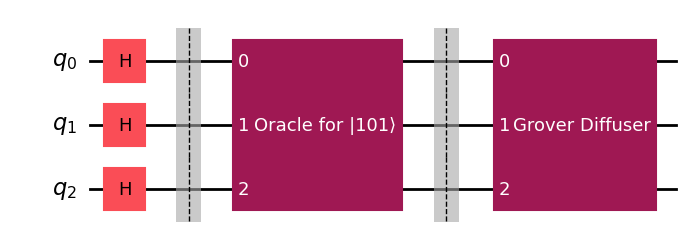

In [3]:
# Third try: Generalized diffuser and oracle

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def create_oracle(n_qubits: int, good_state: str) -> QuantumCircuit:
    """
    Creates an oracle that marks the given good_state with a phase flip.
    
    Parameters:
    - n_qubits: Number of qubits
    - good_state: Bitstring representing the good state (e.g., '101')
    
    Returns:
    - QuantumCircuit implementing the oracle
    """
    qc = QuantumCircuit(n_qubits)

    # Apply X to qubits where good_state is '0'
    for i, bit in enumerate(good_state):
        if bit == '0':
            qc.x(i)

    # Apply multi-controlled-Z (using H + MCX + H)
    qc.h(n_qubits - 1)
    if n_qubits == 2:
        qc.cz(0, 1)
    else:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    # Undo the X gates
    for i, bit in enumerate(good_state):
        if bit == '0':
            qc.x(i)

    qc.name = f"Oracle for |{good_state}⟩"
    return qc

def grover_diffuser(n_qubits: int) -> QuantumCircuit:
    """
    Creates the Grover diffuser circuit for n_qubits.
    """
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    if n_qubits == 2:
        qc.cz(0, 1)
    else:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    qc.name = "Grover Diffuser"
    return qc

n = 3
good_state = "101"

# Define the Grover circuit
grover_circuit = QuantumCircuit(n)

# Initial superposition
grover_circuit.h(range(n))
grover_circuit.barrier()

# Grover oracle
grover_circuit.append(create_oracle(n, good_state), range(n))
grover_circuit.barrier()

# Grover diffuser
grover_circuit.append(grover_diffuser(n), range(n))

# Get final state
final_state = Statevector.from_instruction(grover_circuit)

# Print amplitudes
print("\nFinal quantum state (states' amplitudes):")
print(final_state)

# Draw circuit
grover_circuit.draw("mpl")

In [ ]:
# Fourth try: Apply Grover iterations

from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
from qiskit.quantum_info import Statevector
import math

def create_oracle(n_qubits: int, good_state: str) -> QuantumCircuit:
    """
    Creates an oracle that marks the given good_state with a phase flip.
    """
    qc = QuantumCircuit(n_qubits)
    for i, bit in enumerate(good_state):
        if bit == '0':
            qc.x(i)
    qc.h(n_qubits - 1)
    if n_qubits == 2:
        qc.cz(0, 1)
    else:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    for i, bit in enumerate(good_state):
        if bit == '0':
            qc.x(i)
    qc.name = f"Oracle for |{good_state}⟩"
    return qc

def grover_diffuser(n_qubits: int) -> QuantumCircuit:
    """
    Creates the Grover diffuser circuit for n_qubits.
    """
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    if n_qubits == 2:
        qc.cz(0, 1)
    else:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    qc.name = "Grover Diffuser"
    return qc

# Number of qubits
n = 3
# Good state to search for
good_state = "101"

# Calculate number of Grover iterations
M = 1  # One good solution
N = 2 ** n
optimal_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(M / N))))
print(f"Optimal number of Grover iterations: {optimal_iterations}")

# Create initial Grover circuit with superposition
grover_circuit = QuantumCircuit(n)
grover_circuit.h(range(n))
grover_circuit.barrier()

# Create oracle and diffuser once
oracle = create_oracle(n, good_state)
diffuser = grover_diffuser(n)

# Apply Grover iterations
for _ in range(optimal_iterations):
    grover_circuit.append(oracle, range(n))
    grover_circuit.barrier()
    grover_circuit.append(diffuser, range(n))
    grover_circuit.barrier()

# Final state vector
final_state = Statevector.from_instruction(grover_circuit)

# Show amplitudes
print("\nFinal quantum state (states' amplitudes):")
print(final_state)

# Draw circuit
grover_circuit.draw("mpl")

from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

 ##local simulator
sampler = StatevectorSampler()
grover_circuit.measure_all()
pub=(grover_circuit) #qc es un quantumcircuit
result_sim = sampler.run([pub],shots=1000).result()
dist_sim = result_sim[0].data.meas.get_counts()
plot_distribution(dist_sim)


Optimal number of Grover iterations: 2

Final quantum state (states' amplitudes):
Statevector([-0.08838835+0.j, -0.08838835+0.j, -0.08838835+0.j,
             -0.08838835+0.j, -0.08838835+0.j,  0.97227182+0.j,
             -0.08838835+0.j, -0.08838835+0.j],
            dims=(2, 2, 2))


NameError: name 'plot_distribution' is not defined